In [146]:
# -- coding: utf-8 -- 

Machine learning HW1
*   Nome : Ali
*   Cognome :Nosouhi Dehnavi
*   Matricola: 1950716
*   Email : nosouhidehnavi.1950716@studenti.uniroma1.it
*   14 November 2021





In [1]:
import random
import numpy as np
import pandas as pd
import nltk
import re
import sklearn.metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import *
import matplotlib.pyplot as plt
nltk.download('punkt')
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Libraries imported.")

Libraries imported.


In [3]:
def vectorize(tokens):
    vector=[]
    voc=vocab_without_sw
    for w in voc:
        vector.append(tokens.count(w))
    return vector

def unique(sequence):
    #This functions returns a list in which the order remains same and no item repeats
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

LOAD DATA

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# example path of dataset copied in My Drive folder: /content/drive/My Drive/SMSSpamCollection'
filename = '/content/drive/My Drive/MLHomeWork/mapping_traces_O0.csv'
db = pd.read_csv(filename, sep='\t', header=0 )
print(len(db))

100000


In [6]:
db.head(2)

,instructions,source_line,line_number,function_name,program,bug
0,movl HIGHVAL l 19 1,int32t l 19 1 = ( -8 ) ;,2517,func_47__0,/home/stepping/data_source_asm_trace_p2/proces...,0
1,movl HIGHVAL l 82 6,int32t l 25 73 = ( -1 ) ;,1994,func_25__0,/home/stepping/data_source_asm_trace_p2/proces...,1


In [7]:
# save the list of labels names'
list_of_column_names = list(db.columns)
class_names = np.array(["not "+str(list_of_column_names[-1]),str(list_of_column_names[-1])])
print(class_names)

['not bug' 'bug']


In [8]:
# example path of dataset copied in My Drive folder: /content/drive/My Drive/SMSSpamCollection'
filename = '/content/drive/My Drive/MLHomeWork/blind_test.csv'
db_blind = pd.read_csv(filename, sep='\t', header=0 )
print(len(db_blind))

10000


In [9]:
db_blind.head(2)

,instructions,source_line,line_number,function_name,program
0,movl HIGHVAL MEM cmpl 7 MEM jne MEM,volatile int32t l 48 76 = 0 ;,1903,func_1__0,/home/stepping/data_source_asm_trace_p2/proces...
1,movl MEM %eax subl 1 %eax movl %eax MEM jmp ME...,for ( p 81 = 0 ; ( p 81 > = 0 ) ; p 81...,2238,func_80__0,/home/stepping/data_source_asm_trace_p2/proces...


PREPROCESS main Dataset

In [10]:
dataset=np.array(db)
X=dataset[:,0:2]
Y=dataset[:,-1]


In [11]:
#VOCAB:
vocab=[]
string1=""
string2=""
for i in range(len(X)):
  s1=X[i,0]
  string1=string1+s1
  s2=X[i,1]
  string2=string2+s2

string1=string1.lower()
string2=string2.lower()

tokens1=string1.split()
tokens2=string2.split()
print(np.shape(tokens1))
print(np.shape(tokens2))

vocab.append(unique(tokens1+tokens2))

print("vocab shape is ",np.shape(vocab))
vocab=np.concatenate(vocab)

#Clean Vocab:
from gensim.parsing.preprocessing import STOPWORDS
#,'mov','='
all_stopwords_gensim = STOPWORDS.union(set((['!','(',')','-','[',']','{','}',';',':','"','<','>','.','/','?','@','#','$','^','&','*','_','~','<','>','+','%'])))
vocab_without_sw=[]
for word in vocab:
  for t in all_stopwords_gensim:
    if t in word:
      fl=0
      break
    else:
      fl=1  
  if fl==1:
    vocab_without_sw.append(word)
#vocab_without_sw = [word for word in vocab if not t in word]

print("after cleaning vocab shape is ",np.shape(vocab_without_sw))

(2709193,)
(3667828,)
vocab shape is  (1, 1811)
after cleaning vocab shape is  (957,)


In [12]:
#Vectorize Main Dataset:
seq=[]
for sentence in X:
  tok=sentence[0]+sentence[1]
  tok=tok.lower()
  tok=tok.split()
  vector=vectorize(tok)
  seq.append(vector)
seq=np.array(seq)
print(np.shape(seq))

(100000, 957)


**Fit DT model**

In [13]:
#Split Vectorized main Dataset:
X_all = seq
y_all = Y.astype(int)
print("y_all=", y_all)
print( "X_all size: ",X_all.shape)
print("y_all size: ",y_all.shape)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=16)

print("Train: %d - Test: %d" %(X_train.shape[0],X_test.shape[0]))

y_all= [0 1 0 ... 1 0 0]
X_all size:  (100000, 957)
y_all size:  (100000,)
Train: 70000 - Test: 30000


In [14]:
#Train DT model:
start = time.time()
modelDT = tree.DecisionTreeClassifier()
modelDT.fit(X_train, y_train)
print ("Computaion time of DT ",time.time()- start)

Computaion time of DT  7.090618133544922


**Fit RF model**

In [16]:
#Train RF model:
start=time.time()
modelRF = RandomForestClassifier(random_state=5)
modelRF.fit(X_train, y_train)
print ("Computaion time of RF ",time.time()- start)

Computaion time of RF  46.41435670852661


**Evaluation of DT model:**

In [17]:
#Evaluation of DT model:
#predict on test set
y_pred_DT = modelDT.predict(X_test)
print('Correct Prediction (%): ', accuracy_score(y_test, y_pred_DT, normalize=True)*100.0)
print(confusion_matrix(y_test, y_pred_DT))
report=classification_report(y_test, y_pred_DT)
print(report)

Correct Prediction (%):  92.43
[[13905  1052]
 [ 1219 13824]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     14957
           1       0.93      0.92      0.92     15043

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000



**confusion_matrix of DT model**

[[13905  1052]
 [ 1219 13824]]


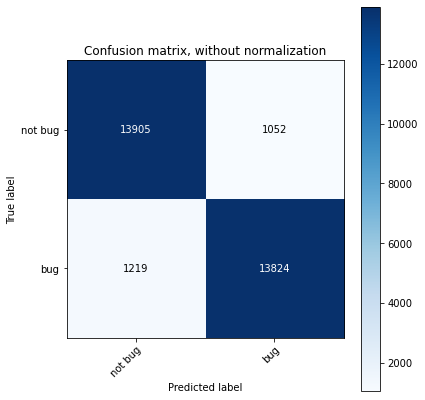

In [18]:
cmDT = confusion_matrix(y_test, y_pred_DT, labels=None, sample_weight=None)
print(cmDT)
plt.rcParams["figure.figsize"] = (6,6)
plot_confusion_matrix(y_test, y_pred_DT, classes=class_names, normalize=False)

**Evaluation of RF model:**

In [19]:
#Evaluation of RF model:
#predict on test set
y_pred_RF = modelRF.predict(X_test)
print('Correct Prediction (%): ', accuracy_score(y_test, y_pred_RF, normalize=True)*100.0)
print(confusion_matrix(y_test, y_pred_RF))
report = classification_report(y_test, y_pred_RF)
print(report)

Correct Prediction (%):  96.02666666666667
[[14637   320]
 [  872 14171]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14957
           1       0.98      0.94      0.96     15043

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000



**confusion_matrix of RF model**

[[14637   320]
 [  872 14171]]


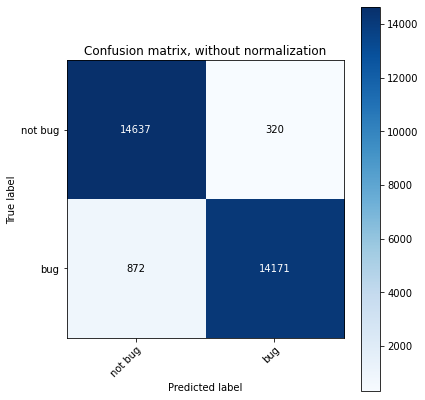

In [20]:
cmRF = confusion_matrix(y_test, y_pred_RF, labels=None, sample_weight=None)
print(cmRF)
plt.rcParams["figure.figsize"] = (6,6)
plot_confusion_matrix(y_test, y_pred_RF, classes=class_names, normalize=False)

**PREPROCESS Blind set**

In [21]:
dataset_blind=np.array(db_blind)
X_blind=dataset_blind[:,0:2]
print(X_blind[58])

['movl 0 l 45 2 ' 'int32t  l  45 2  = 0 ;']


In [22]:
#Vectorize blind Dataset: (With the use of Main data Vocab)
seq_blind=[]
for sentence in X_blind:
  tok=sentence[0]+sentence[1]
  tok=tok.lower()
  tok=tok.split()
  vector=vectorize(tok)
  seq_blind.append(vector)
seq_blind=np.array(seq_blind)
print(np.shape(seq_blind))

(10000, 957)


**Blind set Prediction**

In [23]:
#Predict Blind dataset with DT:
y_pred_blind_DT = modelDT.predict(seq_blind)
print(np.shape(y_pred_blind_DT))
print(y_pred_blind_DT[0:100])
np.count_nonzero(y_pred_blind_DT)

(10000,)
[1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1]


4894

In [24]:
#Predict Blind dataset with RF:
y_pred_blind_RF = modelRF.predict(seq_blind)
print(np.shape(y_pred_blind_RF))
print(y_pred_blind_RF[0:100])
np.count_nonzero(y_pred_blind_RF)

(10000,)
[1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1
 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1]


4746

**compare the result of prediction by 2 models:**

In [25]:
#To compare the result of prediction by 2 models:
err= y_pred_blind_DT+y_pred_blind_RF
count_arr = np.bincount(err)
print("The number of non similar predictions is ", count_arr[1], " out of ", np.shape(err)[0], " predctins ")
print("The percentage of agreement is ", 1-count_arr[1]/np.shape(err)[0], " % ")

The number of non similar predictions is  734  out of  10000  predctins 
The percentage of agreement is  0.9266  % 


 K-Fold Cross Validation 

 

In [26]:
#K-Fold Cross Validation 
cv = ShuffleSplit(n_splits=5, test_size=0.333, random_state=15)
scoresDT = cross_val_score(modelDT, X_all, y_all, cv=cv)
print(scoresDT)
print("Accuracy: %0.3f (+/- %0.4f)" % (scoresDT.mean(), scoresDT.std() * 2))

[0.92222222 0.92189189 0.92273273 0.92429429 0.91894895]
Accuracy: 0.922 (+/- 0.0035)


In [30]:
#K-Fold Cross Validation 
cv = ShuffleSplit(n_splits=5, test_size=0.333, random_state=15)
scoresRF = cross_val_score(modelRF, X_all, y_all, cv=cv)
print(scoresRF)
print("Accuracy: %0.3f (+/- %0.4f)" % (scoresRF.mean(), scoresRF.std() * 2))

[0.95786787 0.95828829 0.96015015 0.95927928 0.956997  ]
Accuracy: 0.959 (+/- 0.0022)


⚖ **Hyper Parameters tuning**

In [31]:
print("depth=",modelDT.get_depth())
print("leaves=",modelDT.get_n_leaves())
modelDT.get_params()

depth= 110
leaves= 4586


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [39]:
param_dict = {"min_samples_split":range(2,4), "min_samples_leaf":range(1,4) }

grid = GridSearchCV(modelDT,param_grid=param_dict, cv=5,verbose=1,n_jobs=-1) 
grid.fit(X_train,y_train) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 4)},
             verbose=1)

In [40]:
grid.best_params_

{'min_samples_leaf': 3, 'min_samples_split': 3}

In [41]:
grid.best_score_

0.9228142857142856

In [151]:
f = open("/content/drive/My Drive/MLHomeWork/1950716-DT.txt", "w",encoding='utf-8')
f.writelines([str(y_pred_blind_DT[i])+"\r\n" for i in range(len(y_pred_blind_DT))])
f.close() 

In [152]:
f = open("/content/drive/My Drive/MLHomeWork/1950716-RF.txt", "w",encoding='utf-8')
f.writelines([str(y_pred_blind_RF[i])+"\r\n" for i in range(len(y_pred_blind_RF))])
f.close() 